# Train with fastai
This Jupyter notebook uses [fastai](https://github.com/fastai/fastai), a Python library for deep learning, to train a convolutional neural network (CNN) on an image dataset. The notebook loads and preprocesses the image data, then uses a pretrained CNN architecture from the [timm](https://github.com/huggingface/pytorch-image-models) library to fine-tune the model on the dataset. Finally, the trained model is saved for future use.

<!--<badge>--><a href="https://colab.research.google.com/github/visual-layer/vl-datasets/blob/master/notebooks/train-fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

## Installation & Setting Up

In [ ]:
!pip install fastai -Uqq
!pip install timm -Uqq
!git clone https://github.com/visual-layer/vl-datasets && cd vl-datasets && pip install .

## Download foods-101 Dataset
Next, we need to download the dataset. For this tutorial, we will use the foods-101 dataset. Run the following commands in your Jupyter notebook to download and extract the dataset:

In [ ]:
!wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
!tar -xf food-101.tar.gz

## Structuring Data

Let's take the above folder structure and turn it into a structure we can readily use with Torchvision.
We will reorganize the above into the following folder structure:

```
food-101/
├── train
│   ├── apple_pie
│   │   ├── 0001.jpg
│   │   └── 0002.jpg
│   ├── baby_back_ribs
│   ├── baklava
│   ├── ...
│   ├── ...
│   ├── ...
│   └── waffles
├── test
│   ├── apple_pie
│   │   ├── 01000.jpg
│   │   └── 01001.jpg
│   ├── baby_back_ribs
│   ├── baklava
│   ├── ...
│   ├── ...
│   ├── ...
│   └── waffles
├── meta
|   ├── classes.txt
│   ├── labels.txt
│   ├── test.json
│   ├── test.txt
│   ├── train.json
│   └── train.txt
├── license_agreement.txt
└── README.txt

```

In order to do that let's run the following code.

In [ ]:
import shutil
import collections
from collections import defaultdict
import os

class_to_ix = {}
ix_to_class = {}
with open('food-101/meta/classes.txt', 'r') as txt:
    classes = [l.strip() for l in txt.readlines()]
    class_to_ix = dict(zip(classes, range(len(classes))))
    ix_to_class = dict(zip(range(len(classes)), classes))
    class_to_ix = {v: k for k, v in ix_to_class.items()}
sorted_class_to_ix = collections.OrderedDict(sorted(class_to_ix.items()))

# Only split files if haven't already
if not os.path.isdir('./food-101/test') and not os.path.isdir('./food-101/train'):

    def copytree(src, dst, symlinks = False, ignore = None):
        if not os.path.exists(dst):
            os.makedirs(dst)
            shutil.copystat(src, dst)
        lst = os.listdir(src)
        if ignore:
            excl = ignore(src, lst)
            lst = [x for x in lst if x not in excl]
        for item in lst:
            s = os.path.join(src, item)
            d = os.path.join(dst, item)
            if symlinks and os.path.islink(s):
                if os.path.lexists(d):
                    os.remove(d)
                os.symlink(os.readlink(s), d)
                try:
                    st = os.lstat(s)
                    mode = stat.S_IMODE(st.st_mode)
                    os.lchmod(d, mode)
                except:
                    pass # lchmod not available
            elif os.path.isdir(s):
                copytree(s, d, symlinks, ignore)
            else:
                shutil.copy2(s, d)

    def generate_dir_file_map(path):
        dir_files = defaultdict(list)
        with open(path, 'r') as txt:
            files = [l.strip() for l in txt.readlines()]
            for f in files:
                dir_name, id = f.split('/')
                dir_files[dir_name].append(id + '.jpg')
        return dir_files

    train_dir_files = generate_dir_file_map('food-101/meta/train.txt')
    test_dir_files = generate_dir_file_map('food-101/meta/test.txt')


    def ignore_train(d, filenames):
        print(d)
        subdir = d.split('/')[-1]
        to_ignore = train_dir_files[subdir]
        return to_ignore

    def ignore_test(d, filenames):
        print(d)
        subdir = d.split('/')[-1]
        to_ignore = test_dir_files[subdir]
        return to_ignore

    copytree('food-101/images', 'food-101/test', ignore=ignore_train)
    copytree('food-101/images', 'food-101/train', ignore=ignore_test)
    
else:
    print('Train/Test files already copied into separate folders.')

## Load Dataset

In [1]:
import torchvision.transforms as transforms

train_transform = transforms.Compose(
    [
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

valid_transform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [ ]:
from vl_datasets import FilteredDataset

In [2]:
train_dataset = FilteredDataset("food-101/train", "food_101_vl-datasets_analysis.csv", transform=train_transform)
valid_dataset = FilteredDataset("food-101/test", "food_101_vl-datasets_analysis.csv", transform=train_transform)

Original Samples: 75750 in food-101/train
Excluded: 498 in food-101/train
Cleaned Samples: 75343 in food-101/train
Original Samples: 25250 in food-101/test
Excluded: 498 in food-101/test
Cleaned Samples: 25159 in food-101/test


In [3]:
train_dataset.excluded_files

,filename,reason,value,prototype
0,food-101/train/apple_pie/1487150.jpg,Duplicate,0.9662,apple_pie/1486972.jpg
1,food-101/train/apple_pie/3324492.jpg,Duplicate,0.9817,apple_pie/2106005.jpg
2,food-101/train/apple_pie/3670966.jpg,Duplicate,0.9879,apple_pie/3670548.jpg
3,food-101/train/apple_pie/839845.jpg,Duplicate,0.9964,apple_pie/839808.jpg
4,food-101/train/baby_back_ribs/2306066.jpg,Duplicate,0.9862,baby_back_ribs/2306008.jpg
...,...,...,...,...
508,food-101/train/sashimi/241368.jpg,Dark,15.7813,NaN
509,food-101/train/scallops/3314913.jpg,Dark,13.7173,NaN
510,food-101/train/spring_rolls/182658.jpg,Dark,8.9502,NaN
511,food-101/train/bread_pudding/444890.jpg,File-Size,9715.0000,NaN


In [4]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=256, shuffle=True, pin_memory=True)

Convert PyTorch `Dataloader` to fastai `Dataloader` class.

In [5]:
from fastai.data.core import DataLoaders
dls = DataLoaders(train_loader, valid_loader)

## Import Libraries

The `fastai.vision.all` module contains all the classes and functions for computer vision tasks in the fastai library, while the timm library provides a collection of state-of-the-art CNN architectures for image classification.

In [ ]:
from fastai.vision.all import *

## Define and Train the Model

The next step is to define and train the CNN model using the Fastai library. The following code defines a vision learner with the convnext_tiny_in22k architecture from the timm library and the accuracy metric.

The vision_learner function creates a CNN model with the specified architecture and data, and the metrics argument specifies the evaluation metric to use during training. In this case, the accuracy metric is used to measure the percentage of correctly classified images. The to_fp16 method is used to convert the model to half-precision floating-point format, which reduces memory usage and speeds up training.

In [6]:
learn = Learner(dls, resnet18(), loss_func=nn.CrossEntropyLoss(),  metrics=accuracy).to_fp16()

The next step is to find the optimal learning rate for training the model using the following code:

SuggestedLRs(valley=0.001737800776027143)

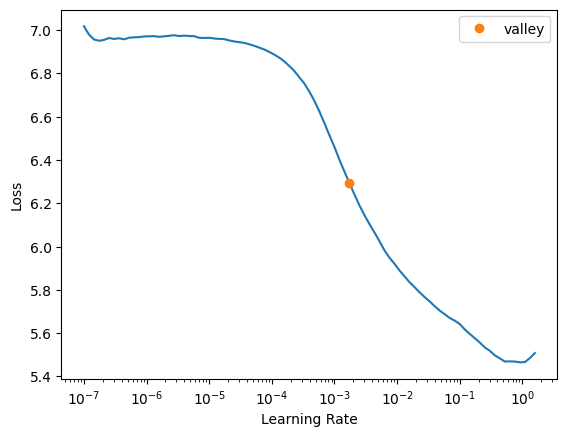

In [7]:
learn.lr_find()

This function finds the learning rate that results in the steepest decrease in the loss function during training, which is a good starting point for fine-tuning the model.

Finally, the following code is used to fine-tune the model on the dataset for 5 epochs with a learning rate of 1e-3 and a ShowGraphCallback to plot the training and validation loss over time:



epoch,train_loss,valid_loss,accuracy,time
0,4.032237,4.073100,0.088597,05:44


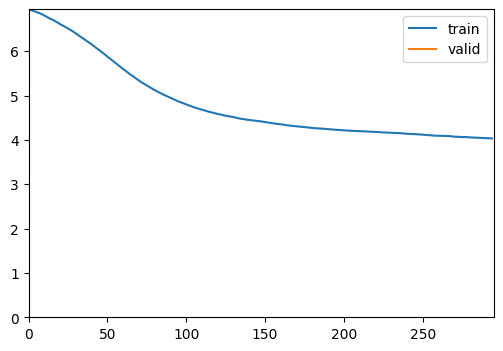

epoch,train_loss,valid_loss,accuracy,time
0,3.493984,3.550112,0.178783,05:31
1,3.217358,3.378192,0.205453,05:24
2,2.852798,2.910805,0.292023,05:17
3,2.558197,2.402851,0.403196,04:57
4,2.385514,2.249424,0.444771,04:51


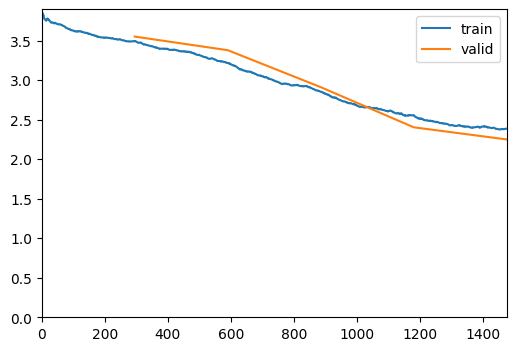

In [8]:
learn.fine_tune(5, base_lr=1e-3, cbs=[ShowGraphCallback()])

The fine_tune method is used to fine-tune the model on the dataset for the specified number of epochs, and the base_lr argument specifies the learning rate to use for the final layers of the model. The ShowGraphCallback is a custom callback that plots the training and validation loss over time.



## Evaluate Results
Once of the ways to learn about the performance of your model is to evaluate it on the validation set. For classification tasks it's easy to use confusion matrix to gauge the model performance.

In [59]:
# interp = ClassificationInterpretation.from_learner(learn)
# interp.plot_confusion_matrix(figsize=(5,5), dpi=60)

## Export the Trained Model

The export method is used to save the model to a file with the specified path and name. This trained model can be loaded later for inference or further fine-tuning.

In [61]:
# learn.export("./models/learner.pkl")

That's it! This notebook shows how to train a CNN model using the Fastai library with a pretrained architecture from the timm library. By following the steps in this notebook, you can easily train your own CNN models on image datasets using fastai.



